# №4 Скидки и продажи

**Формулировка гипотезы**  

H₀: Скидки не оказывают значимого влияния на продажи.  
H₁: Скидки увеличивают продажи (средний чек).  

**Тесты**
- Welch t-test (на логарифмически преобразованных данных)
    - Размер эффекта Cliff’s Delta

### Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy
import configparser
from scipy.stats import skew, kurtosis
import numpy as np
from scipy import stats
 # Импортируем класс из файла db_connection.py
from db_connection import PostgresConnection
# Импортируем класс из файла data_cleaner.py
from data_cleaner import DataCleaner

In [2]:
# Создаем объект для работы с базой данных
db_connection = PostgresConnection()

query = 'SELECT * FROM sales'
data = db_connection.execute_query(query)

### Подготовка данных

In [3]:
# Создаем объект DataCleaner с данным DataFrame
cleaner = DataCleaner(data)

# Удаляем строки с отрицательными значениями в 'dr_sdisc' и 'dr_kol'
cleaned_data = cleaner.drop_negative_values()

# Удаляем строки, где 'dr_nchk' имеет значения из списка [21, 593, 2495]
cleaned_data = cleaner.drop_error_check_values()

### Формирование чеков

In [4]:
cleaned_data['price_without_discount'] = cleaned_data['dr_croz'] * cleaned_data['dr_kol']
grouped = cleaned_data.groupby(['dr_tabempl', 'dr_apt', 'dr_nchk', 'dr_dat']).agg({'price_without_discount':'sum',\
                                                            'dr_sdisc':'max'}).reset_index()
grouped['final_price'] = grouped['price_without_discount'] - grouped['dr_sdisc']
grouped.head()

,dr_tabempl,dr_apt,dr_nchk,dr_dat,price_without_discount,dr_sdisc,final_price
0,15,11,2491,2022-05-03,8706.0,0.0,8706.0
1,15,11,2497,2022-05-04,2677.0,0.0,2677.0
2,15,11,2499,2022-05-04,2150.0,0.0,2150.0
3,15,11,2501,2022-05-04,959.0,0.0,959.0
4,15,11,2503,2022-05-04,1194.0,0.0,1194.0


### EDA

**Формирование выборок**

In [5]:
# 1. Создание бинарного признака наличия скидки
grouped["has_discount"] = (grouped["dr_sdisc"] > 0).astype(int)

**Статистика по группам**

In [6]:
# 2. Проверим распределение по группам
grouped.groupby('has_discount')['final_price'].agg(
    mean='mean',
    median='median',
    count='count'
).reset_index().round(2)

,has_discount,mean,median,count
0,0,493.71,269.0,13379
1,1,742.39,424.0,7603


**Визуализация распределений**

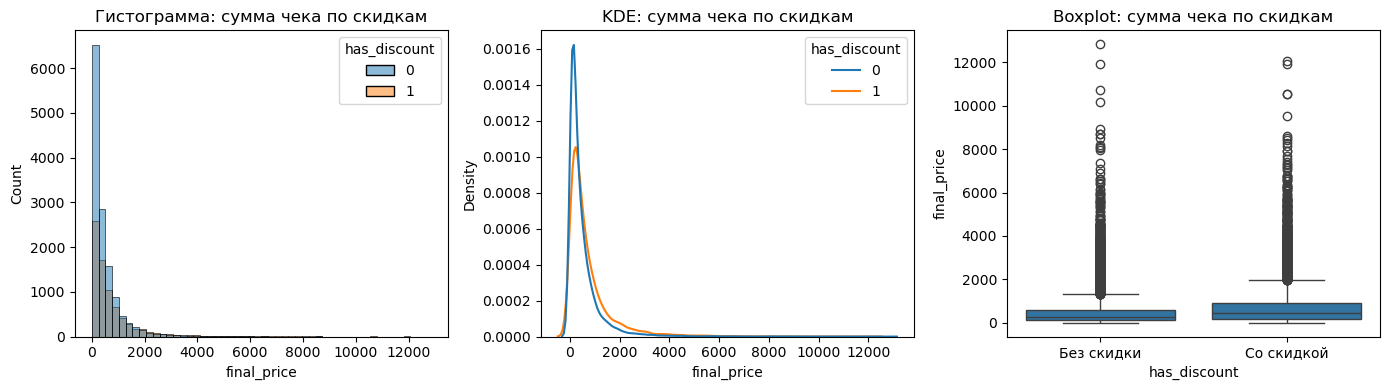

In [7]:
# Визуализации
plt.figure(figsize=(14, 4))

# 1. -- Гистограмма
plt.subplot(1, 3, 1)
sns.histplot(data=grouped, x="final_price", hue="has_discount", kde=False, bins=50)
plt.title("Гистограмма: сумма чека по скидкам")

# 2. -- KDE (плотность распределения)
plt.subplot(1, 3, 2)
sns.kdeplot(data=grouped, x="final_price", hue="has_discount", common_norm=False)
plt.title("KDE: сумма чека по скидкам")

# 3. -- Boxplot
plt.subplot(1, 3, 3)
sns.boxplot(data=grouped, x="has_discount", y="final_price")
plt.title("Boxplot: сумма чека по скидкам")
plt.xticks([0, 1], ["Без скидки", "Со скидкой"])

plt.tight_layout()
plt.show()


Гистограмма:
- Распределение скошено вправо (большинство чеков — с маленькой суммой, но есть редкие дорогие покупки).
- И со скидкой, и без скидки — пики в районе до 1000 единиц.
- Чеки со скидкой немного смещены вправо — то есть в среднем чуть дороже.

KDE-график (сглаженная оценка плотности распределения):
- Подтверждает выводы из гистограммы.
- Графики плотности указывают:
    - Основная масса чеков и в той, и в другой группе лежит в пределах до 2000.
    - Пик у чеков без скидки чуть выше и левее, что говорит о немного меньших средних суммах.
    - Чеки со скидкой имеют чуть более "тяжёлый хвост", т.е. среди них чаще встречаются большие суммы.

Boxplot (диаграмма размаха):
- Медиана у обеих групп очень близка (немного выше при наличии скидки).
- IQR (межквартильный размах) немного шире для чеков со скидкой (типичные суммы чеков со скидкой более разнообразны — больше разброс в том, сколько люди тратят при наличии скидок).
- Выбросов (очень больших чеков) много в обеих группах, особенно в группе со скидкой.
- Это может указывать, что скидки привлекают покупателей на более дорогие покупки (например, покупка "впрок" или дорогих товаров при акциях).

**Интерпретация результатов**     
- Чеки со скидками в среднем чуть дороже и имеют более тяжёлое распределение хвоста (т.е. больше высоких значений).
- Однако распределения в целом похожи — с сильной асимметрией, множеством малых значений и большим количеством выбросов.
- Возможно, скидки стимулируют к более дорогим или объёмным покупкам, но разница не кардинальна.

## Welch t-test

### Лог-преобразование

In [8]:
# 1. Лог-преобразование (добавляем +1, чтобы избежать log(0))
grouped["log_final_price"] = np.log1p(grouped["final_price"])

# 2. Делим на группы: со скидкой vs без скидки
with_discount = grouped.loc[grouped["has_discount"] == 1, "log_final_price"]
without_discount = grouped.loc[grouped["has_discount"] == 0, "log_final_price"]

**Диагностика нормальности с использованием скоса и эксцесса**

In [9]:
print("Skew with_discount:", skew(with_discount))
print("Kurtosis with_discount:", kurtosis(with_discount))
print("Skew without_discount:", skew(without_discount))
print("Kurtosis without_discount:", kurtosis(without_discount))

Skew with_discount: -0.2765411028771507
Kurtosis with_discount: 0.43648919647426565
Skew without_discount: -0.10965187228571839
Kurtosis without_discount: -0.20409075785360686


1. Skewness (Асимметрия):   
- with_discount: -0.2765  
- without_discount: -0.1097  

Асимметрия, близкая к нулю, говорит о симметричном распределении.  
Значения между -0.5 и 0.5 считаются слабо асимметричными, и это допустимо для t-теста.  

2. Kurtosis (Эксцесс):  
- with_discount: 0.4365  
- without_discount: -0.2041  
 
Для нормального распределения эксцесс должен быть близок к 0.  
Значения в пределах ±1 считаются допустимыми для нормального распределения.  

**Графический анализ нормальности данных**

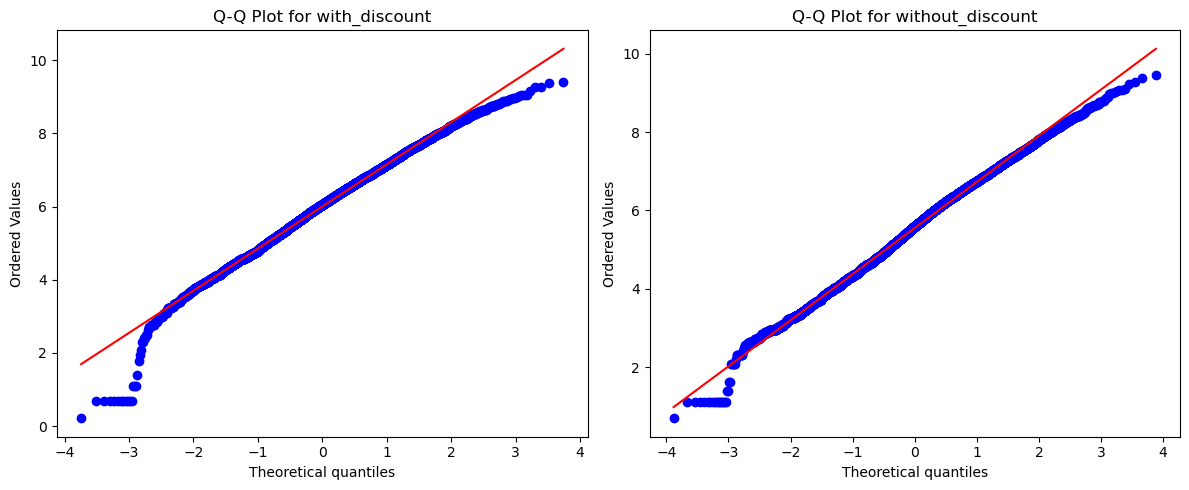

In [10]:
# Создание фигуры и осей
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Первый график Q-Q
stats.probplot(with_discount, dist="norm", plot=axes[0])
axes[0].set_title("Q-Q Plot for with_discount")

# Второй график Q-Q
stats.probplot(without_discount, dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot for without_discount")

# Настройка и показ графиков
fig.tight_layout()
plt.show()

- В обоих случаях точки в целом располагаются вдоль диагонали, что говорит о частичном соответствии нормальному распределению.  
- Однако в нижних квантилях (левый хвост) наблюдаются существенные отклонения от прямой линии. Особенно это заметно на графике with_discount, где значения сильно ниже теоретических.  
Лог-преобразование приблизило распределения к нормальному, однако обе выборки по-прежнему демонстрируют отклонения от нормальности, особенно в нижних квантилях.   

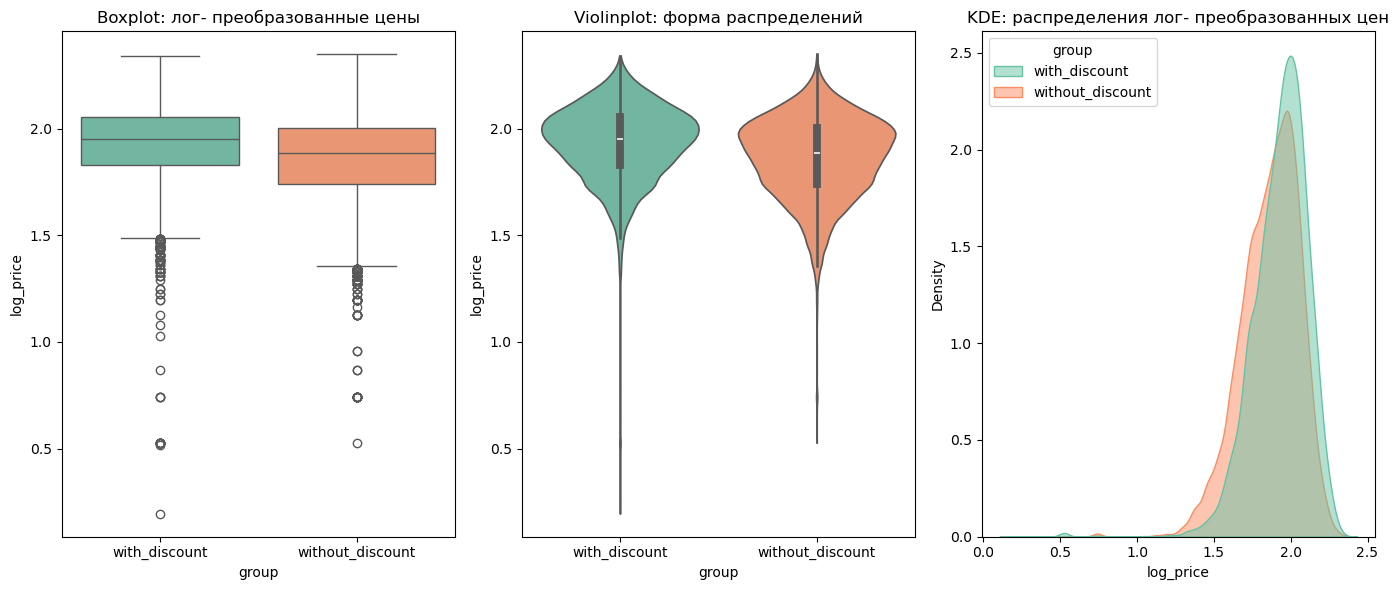

In [11]:
# Лог-преобразование данных
with_log = np.log1p(with_discount)
without_log = np.log1p(without_discount)

# Делаем датафрейм в "long" формате для seaborn
df_plot = pd.DataFrame({
    "log_price": np.concatenate([with_log, without_log]),
    "group": ["with_discount"] * len(with_log) + ["without_discount"] * len(without_log)
})

plt.figure(figsize=(14, 6))

# 1. --- Boxplot ---
plt.subplot(1, 3, 1)
sns.boxplot(x="group", y="log_price", hue="group", 
            data=df_plot, palette="Set2", legend=False)
plt.title("Boxplot: лог- преобразованные цены")

# 2. --- Violinplot ---
plt.subplot(1, 3, 2)
sns.violinplot(x="group", y="log_price", hue="group", 
               data=df_plot, palette="Set2", legend=False, cut=0)
plt.title("Violinplot: форма распределений")

# 3. --- KDE Plot ---
plt.subplot(1, 3, 3)
sns.kdeplot(data=df_plot, x="log_price", hue="group", 
            fill=True, common_norm=False, palette="Set2", alpha=0.5)
plt.title("KDE: распределения лог- преобразованных цен")

plt.tight_layout()
plt.show()

**Интерпретация результатов**   
(Boxplot, Violinplot, KDE)   
- Распределения чеков со скидкой и без скидки схожи по форме, но сдвинуты.  
- У чеков со скидкой (зелёный цвет) медиана и плотность чуть выше, следовательно, клиенты со скидкой чаще делают более дорогие чеки.  

### Проверка предпосылок

Оба распределения достаточно близки к нормальному.
Welch’s t-test является робастным к умеренным отклонениям от нормальности, особенно при средних или больших выборках (n > 30).
Поэтому мы можем считать, что условия для Welch’s t-test выполнены, и его можно применять к этим данным.

### Проведение теста

In [12]:
# ============================
# 1. Welch’s t-test
# ============================
# Welch t-test (equal_var=False)
t_stat, p_val = stats.ttest_ind(without_discount, with_discount, equal_var=False)

print("=== Welch t-test (log-преобразованные данные) ===")
print(f"t-статистика: {t_stat}")
print(f"p-значение: {p_val}")

# Интерпретация
alpha = 0.05
if p_val < alpha:
    print("Отвергаем H0: различия статистически значимы (p <= 0.05). Определяем меру размера эффекта...")
else:
    print("Не отвергаем H0: статистически значимых различий не выявлено.") 

# ============================
# 2. Cliff's Delta
# ============================
# Оценка практической значимости различий.
def cliffs_delta(x, y):
    """
    Вычисляет Cliff's Delta и категорию эффекта.
    """
    n_x = len(x)
    n_y = len(y)
    # Подсчёт попарных сравнений
    more = sum([np.sum(xi > y) for xi in x])
    less = sum([np.sum(xi < y) for xi in x])
    delta = (more - less) / (n_x * n_y)

    # Категории эффекта (по Romano et al., 2006)
    abs_delta = abs(delta)
    if abs_delta < 0.147:
        size = "negligible"
    elif abs_delta < 0.33:
        size = "small"
    elif abs_delta < 0.474:
        size = "medium"
    else:
        size = "large"
    
    return delta, size

delta, size = cliffs_delta(with_log, without_log)
print("\n=== Сила эффекта ===")
print(f"Cliff's Delta: {delta:.3f}")
print(f"Effect size category: {size}")

=== Welch t-test (log-преобразованные данные) ===
t-статистика: -26.98737455445055
p-значение: 6.393088983546486e-157
Отвергаем H0: различия статистически значимы (p <= 0.05). Определяем меру размера эффекта...

=== Сила эффекта ===
Cliff's Delta: 0.216
Effect size category: small


**Результаты**  
Статистический тест Welch t-test на логарифмически преобразованных данных показал:  
- t-статистика = -26.99, p ≈ 6.4e-157, результат сильно значим.  
- Это значит, что вероятность случайного различия крайне мала. Различия между группами реальны.  

Размер эффекта Cliff’s Delta показал:  
- Δ = 0.216, малый, но не пренебрежимо малый эффект.  
- Это значит, что вероятность того, что случайно выбранный чек со скидкой будет больше, чем чек без скидки, на ~21.6% выше, чем наоборот.
  
Результаты показывают, что скидки статистически значимо повышают продажи (средний чек при скидках отличается от продаж без скидок, p < 0.001).
Однако размер эффекта невелик (δ ≈ 0.22), что означает: влияние скидок на поведение покупателей существует, но ограничено — большинство продаж не демонстрирует резкого роста даже при наличии скидки.

**Значение для бизнеса:**

Скидки эффективны как тактический инструмент для стимулирования продаж, однако их влияние умеренное — массовое снижение цен не гарантирует пропорционального увеличения выручки.
Чрезмерное использование скидок может снижать маржу без ощутимого роста оборота.
Эффект вероятно гетерогенен по группам товаров или категориям клиентов — в некоторых сегментах скидки дают больший прирост.
- Скидки работают как стимул: клиенты покупают чуть больше (или дороже), чем без скидки.   
- Но их влияние не настолько велико, чтобы опираться только на акции как на ключевой драйвер роста. 
- Возможно, сочетание скидок с другими инструментами (мерчандайзинг, программы лояльности) даст больший результат.  

**Рекомендации:**
1. Оптимизировать стратегию скидок — фокусировать промоакции на товарах с высокой эластичностью спроса и низкой маржинальной чувствительностью.
2. Анализировать эффект скидок по категориям (товар, поставщик, аптека, форма оплаты) для выявления сегментов, где скидки действительно стимулируют рост.
3. Использовать персонализированные скидки (например, по истории покупок или корзине клиента), чтобы увеличить отдачу при меньшем снижении цены.
4. Включить фактор скидки в многофакторные модели продаж, чтобы отделить его влияние от сезонности, сотрудника и локации.